In [4]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
import re
from scipy.stats import sem, t

### Helper Methods

In [5]:
def extract_throughputs(file_path):
    """
    Extracts the throughputs from the .txt file(s) in the data folder of this repository.
    Works with files that contain either "Testing I/O size" or "Testing stride size."
    """
    results = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()

    current_size = None
    throughput_pattern = re.compile(r"Throughput: ([\d.]+) MB/s")
    size_pattern = re.compile(r"Testing (I/O|stride) size: ([\d.]+) KB")  # Generalized pattern

    for line in lines:
        size_match = size_pattern.search(line)
        throughput_match = throughput_pattern.search(line)

        if size_match:
            current_size = float(size_match.group(2))  # Capture size value
            results[current_size] = []  # Initialize list for this size
        elif throughput_match and current_size is not None:
            throughput = float(throughput_match.group(1))  # Capture throughput value
            results[current_size].append(throughput)

    return results


In [6]:
def calculate_statistics(data):
    """
    Calculate mean and 95% confidence intervals for each I/O size.

    Args:
        data (dict): A dictionary where keys are I/O sizes and values are lists of throughputs.

    Returns:
        dict: A dictionary where each key is an I/O size and the value is a tuple (mean, lower_bound, upper_bound).
    """
    stats = {}
    for size, throughputs in data.items():
        mean = np.mean(throughputs)
        n = len(throughputs)
        if n > 1:
            std_err = sem(throughputs)
            confidence = t.ppf(0.975, df=n-1) * std_err  # 95% CI
        else:
            confidence = 0  # No confidence interval for a single data point
        stats[size] = (mean, mean - confidence, mean + confidence)
    return stats

In [7]:
def plot_throughput(stats, title, x_label, y_label):
    """
    Plots throughput against the variable under test (e.g., I/O size or stride size).

    Args:
        stats (dict): Dictionary where keys are x-axis values (e.g., I/O sizes in KB)
                      and values are lists of throughputs (MB/s).
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
    """
    x_values = list(stats.keys())
    means = [np.mean(stats[x]) for x in x_values]
    errors = [
        t.ppf(0.975, len(stats[x]) - 1) * sem(stats[x]) if len(stats[x]) > 1 else 0
        for x in x_values
    ]

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        x_values, means, yerr=errors, fmt='o-', capsize=5, label='Mean Throughput'
    )
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.show()


In [8]:
def plot_stride_vs_throughput_multiple_io_sizes(data_list, io_sizes, title, x_label, y_label):
    """
    Plots throughput against stride size for multiple I/O sizes, with each I/O size having its own line.

    Args:
        data_list (list): List of throughput data (each corresponding to a different I/O size).
                          Each item in the list is a dictionary with stride sizes as keys and throughputs as values.
                          Example: [{'stride_size': [throughputs]}, {...}]
        io_sizes (list): List of I/O sizes to plot (in KB or MB).
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
    """
    # Prepare the plot
    plt.figure(figsize=(12, 8))

    # Loop over each I/O size and plot its corresponding data
    for data, io_size in zip(data_list, io_sizes):
        stride_sizes = sorted(data.keys())  # Stride sizes
        means = []
        errors = []

        # Calculate mean and confidence interval for each stride size
        for stride in stride_sizes:
            throughputs = data[stride]
            mean = np.mean(throughputs)
            error = t.ppf(0.975, len(throughputs) - 1) * sem(throughputs) if len(throughputs) > 1 else 0
            means.append(mean)
            errors.append(error)

        # Plot the data with error bars
        plt.errorbar(
            stride_sizes, 
            means, 
            yerr=errors, 
            fmt='-o', 
            label=f'I/O Size: {io_size}', 
            capsize=5
        )

    # Finalize the plot
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend(title="I/O Sizes")
    plt.show()

## Plotting

### HDD Sequential I/O Size Reads

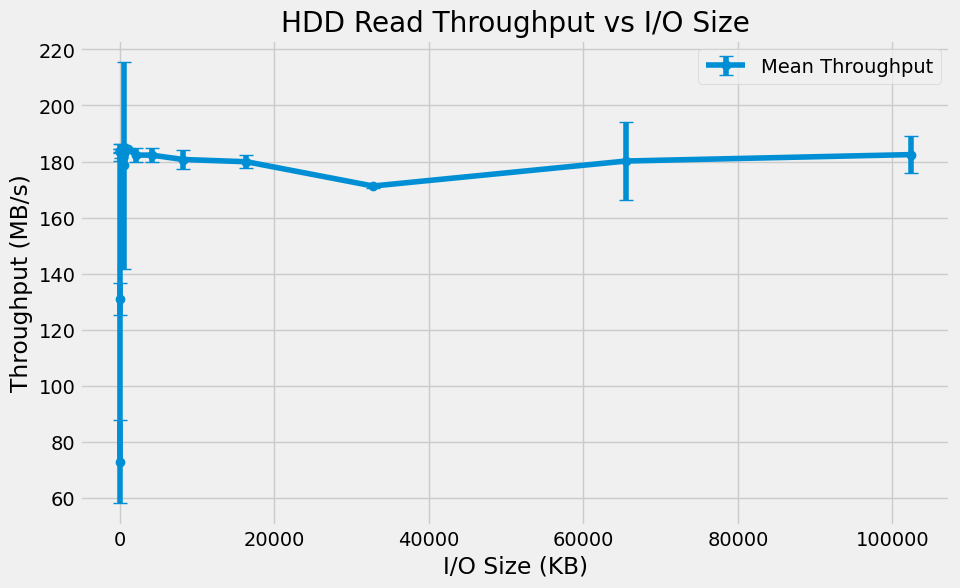

In [9]:
data = extract_throughputs('../data/HDD/sequential/read/io_size.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='HDD Read Throughput vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)


### HDD Sequential I/O Size Writes

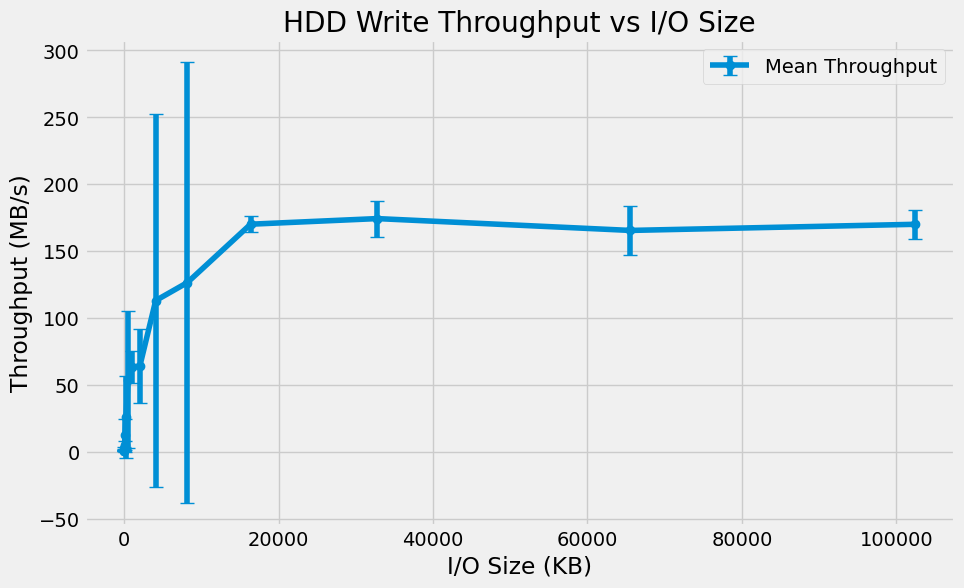

In [30]:
data = extract_throughputs('../data/HDD/sequential/write/io_size.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='HDD Write Throughput vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)


### HDD Sequential Stride Reads

/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


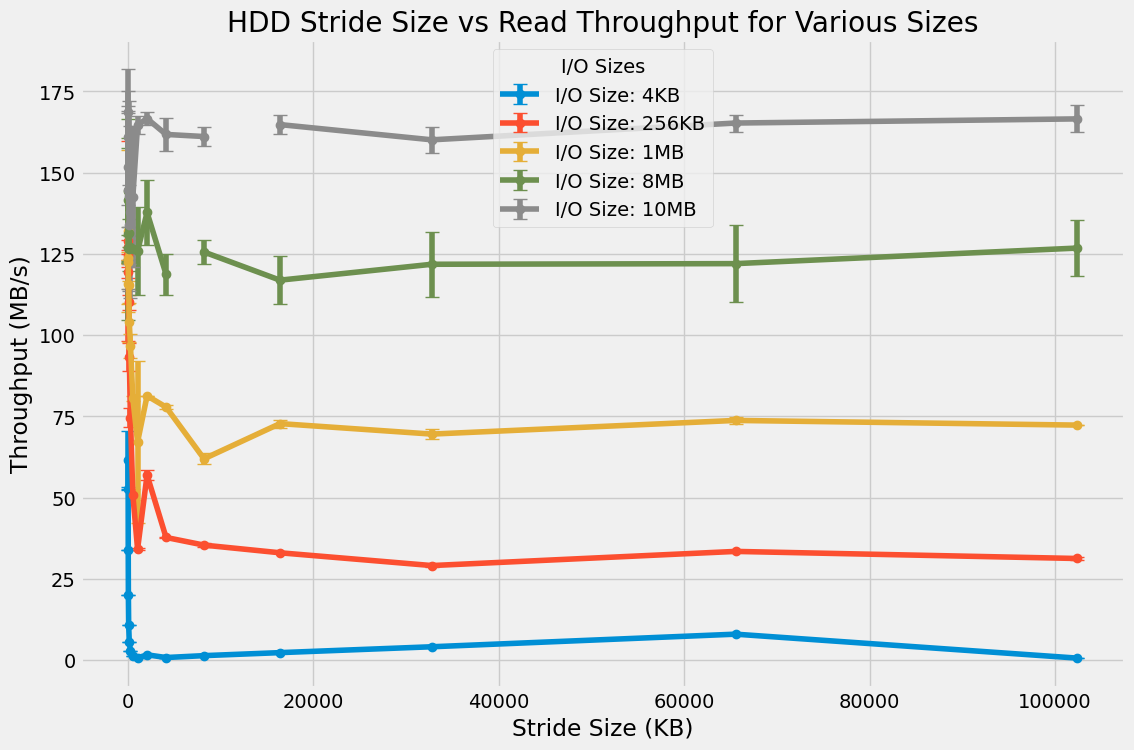

In [31]:
data1 = extract_throughputs('../data/HDD/sequential/read/stride/KB_4.txt')
data2 = extract_throughputs('../data/HDD/sequential/read/stride/KB_256.txt')
data3 = extract_throughputs('../data/HDD/sequential/read/stride/MB_1.txt')
data4 = extract_throughputs('../data/HDD/sequential/read/stride/MB_8.txt')
data5 = extract_throughputs('../data/HDD/sequential/read/stride/MB_10.txt')

# Combine all data into a list
data_list = [data1, data2, data3, data4, data5]

# Corresponding I/O sizes
io_sizes = ['4KB', '256KB', '1MB', '8MB', '10MB']

plot_stride_vs_throughput_multiple_io_sizes(
    data_list,
    io_sizes,
    title='HDD Stride Size vs Read Throughput for Various Sizes',
    x_label='Stride Size (KB)',
    y_label='Throughput (MB/s)'
)


### HDD Sequential Stride Writes

In [12]:
data = extract_throughputs('../data/HDD/sequential/write/stride/KB_4.txt')

### HDD Random I/O Reads

In [13]:
data = extract_throughputs('../data/HDD/random/random_reads.txt')
stats = calculate_statistics(data)

# plot_throughput(
#     stats,
#     title='HDD Read Throughput vs I/O Size',
#     x_label='I/O Size (KB)',
#     y_label='Throughput (MB/s)',
# )


### HDD Random I/O Writes

In [14]:
data = extract_throughputs('../data/HDD/random/random_writes.txt')
stats = calculate_statistics(data)

# plot_throughput(
#     stats,
#     title='HDD Read Throughput vs I/O Size',
#     x_label='I/O Size (KB)',
#     y_label='Throughput (MB/s)',
# )


### SSD Sequential I/O Size Reads

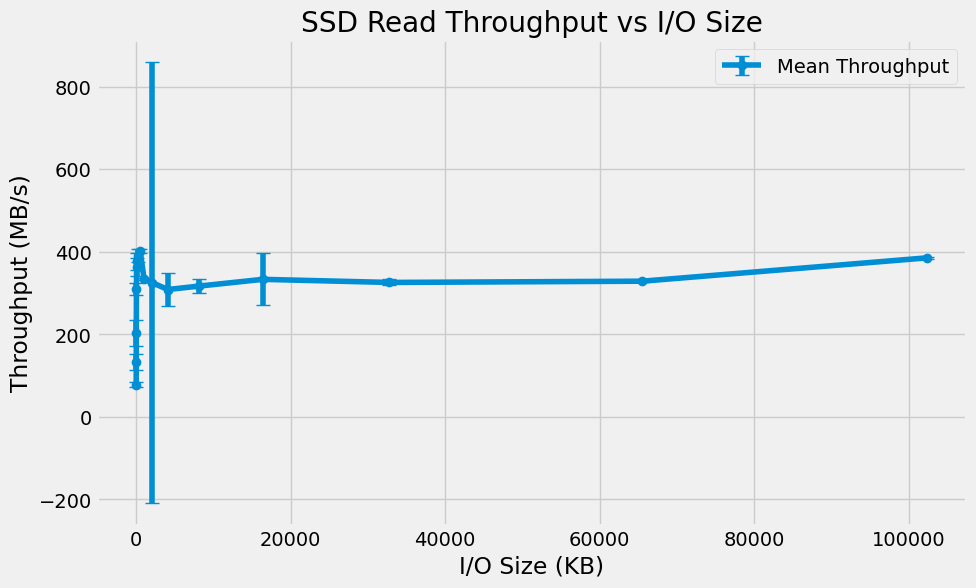

In [15]:
data = extract_throughputs('../data/SSD/sequential/read/io_size.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='SSD Read Throughput vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)


### SSD Sequential I/O Writes

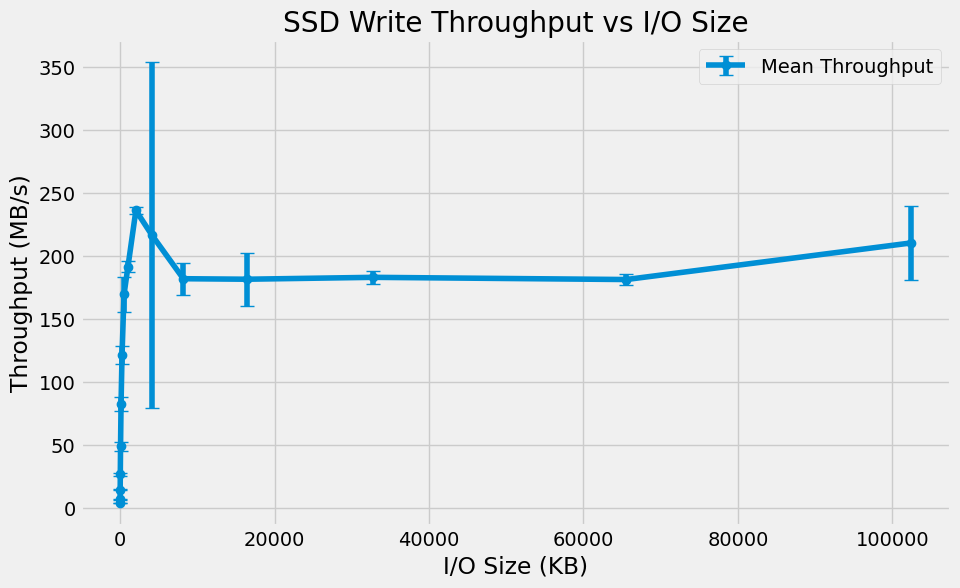

In [21]:
data = extract_throughputs('../data/SSD/sequential/write/io_size.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='SSD Write Throughput vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)


### SSD Sequential Stride Reads

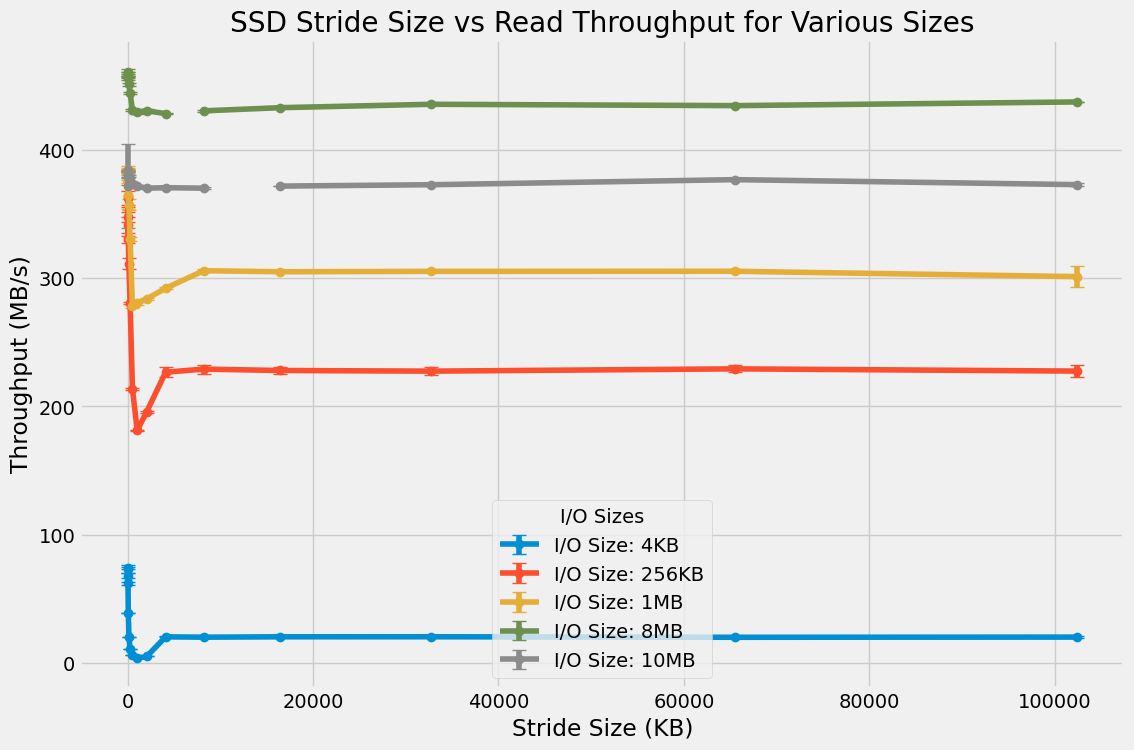

In [25]:
data1 = extract_throughputs('../data/SSD/sequential/read/stride/KB_4.txt')
data2 = extract_throughputs('../data/SSD/sequential/read/stride/KB_256.txt')
data3 = extract_throughputs('../data/SSD/sequential/read/stride/MB_1.txt')
data4 = extract_throughputs('../data/SSD/sequential/read/stride/MB_8.txt')
data5 = extract_throughputs('../data/SSD/sequential/read/stride/MB_10.txt')

# Combine all data into a list
data_list = [data1, data2, data3, data4, data5]

# Corresponding I/O sizes
io_sizes = ['4KB', '256KB', '1MB', '8MB', '10MB']

plot_stride_vs_throughput_multiple_io_sizes(
    data_list,
    io_sizes,
    title='SSD Stride Size vs Read Throughput for Various Sizes',
    x_label='Stride Size (KB)',
    y_label='Throughput (MB/s)'
)


### SSD Sequential Stride Writes

/usr/local/lib/python3.10/dist-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


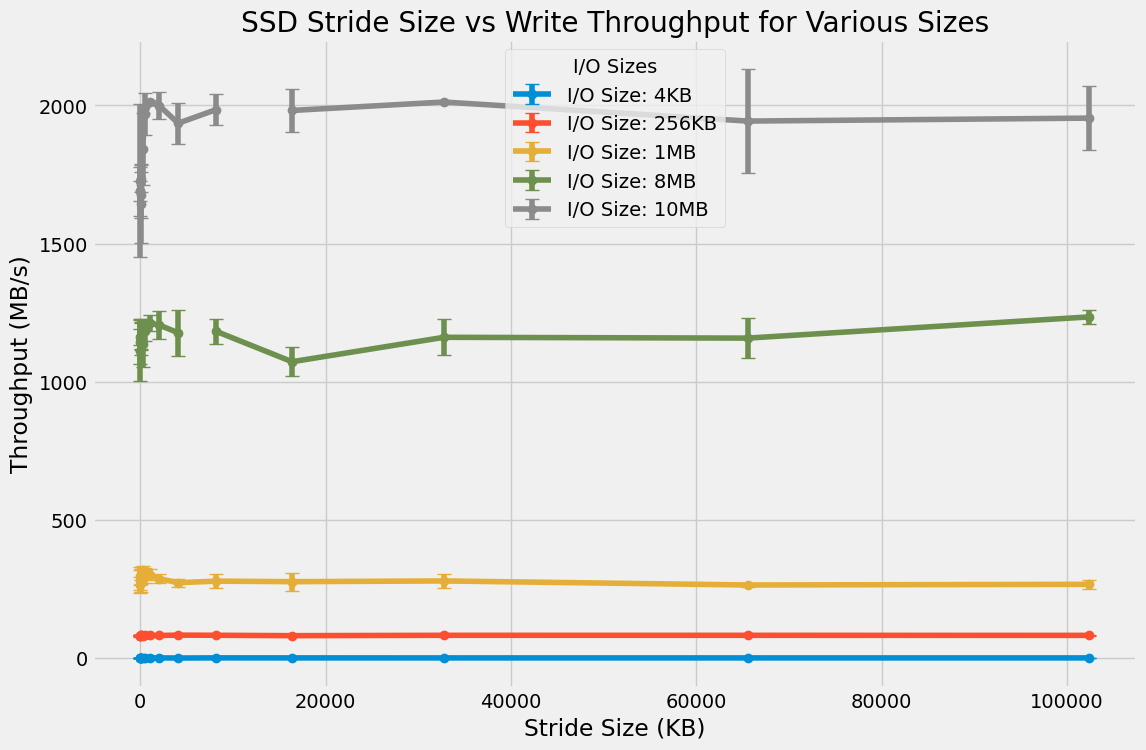

In [29]:
data1 = extract_throughputs('../data/SSD/sequential/write/stride/KB_4.txt')
data2 = extract_throughputs('../data/SSD/sequential/write/stride/KB_256.txt')
data3 = extract_throughputs('../data/SSD/sequential/write/stride/MB_1.txt')
data4 = extract_throughputs('../data/SSD/sequential/write/stride/MB_8.txt')
data5 = extract_throughputs('../data/SSD/sequential/write/stride/MB_10.txt')
stats = calculate_statistics(data)

# Combine all data into a list
data_list = [data1, data2, data3, data4, data5]

# Corresponding I/O sizes
io_sizes = ['4KB', '256KB', '1MB', '8MB', '10MB']

plot_stride_vs_throughput_multiple_io_sizes(
    data_list,
    io_sizes,
    title='SSD Stride Size vs Write Throughput for Various Sizes',
    x_label='Stride Size (KB)',
    y_label='Throughput (MB/s)'
)


### SSD Random I/O Reads

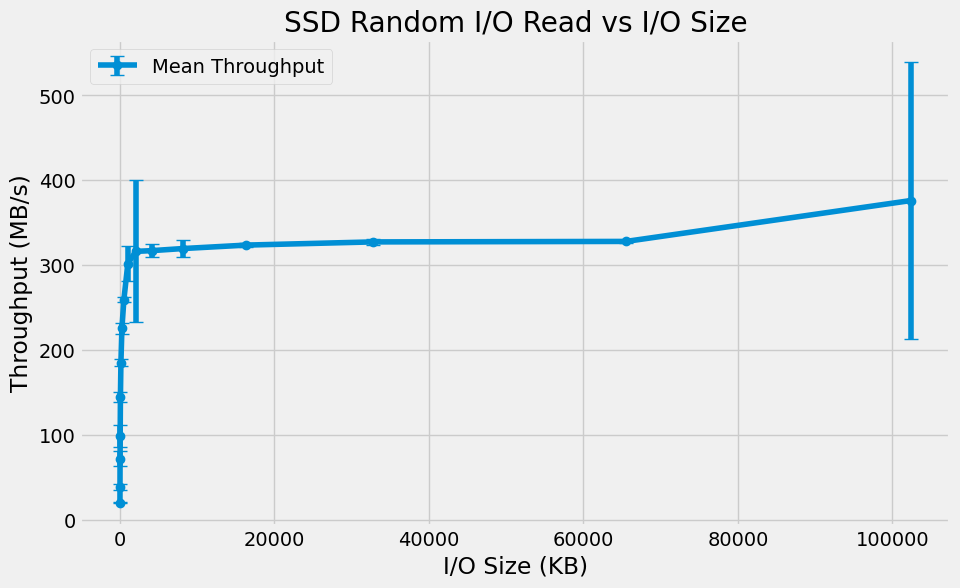

In [26]:
data = extract_throughputs('../data/SSD/random/random_reads.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='SSD Random I/O Read vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)


### SSD Random I/O Writes

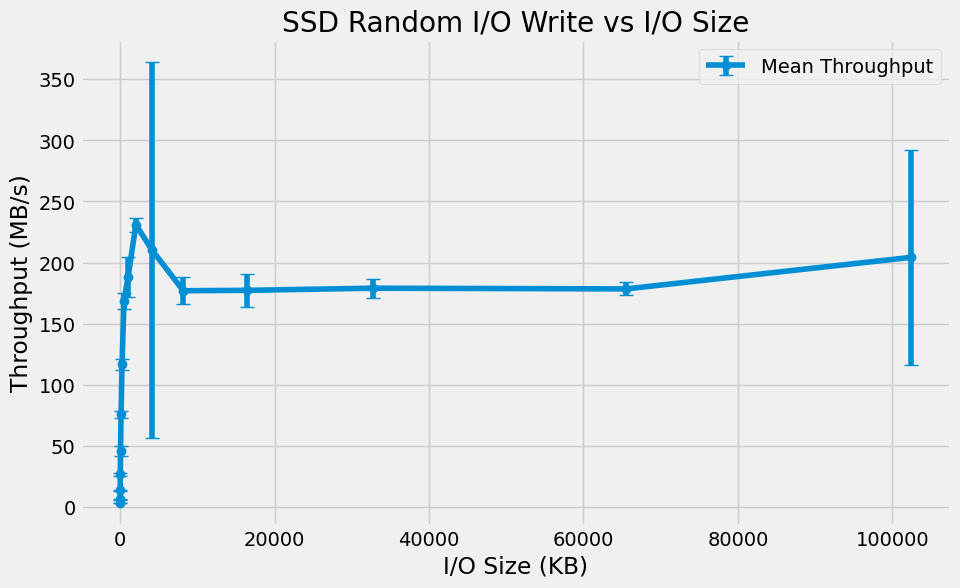

In [27]:
data = extract_throughputs('../data/SSD/random/random_writes.txt')
stats = calculate_statistics(data)

plot_throughput(
    stats,
    title='SSD Random I/O Write vs I/O Size',
    x_label='I/O Size (KB)',
    y_label='Throughput (MB/s)',
)
